Business objective

# Read the data

In [1]:
# Import necessary packages
import pandas as pd
import pandas.util.testing as tm
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import time
from datetime import datetime
from datetime import date

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

/Users/Edite/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
# Read the data
df= pd.read_csv("UK Road Accidents 2018.csv")

### Random sample of data
df.sample(n) shows more variation in the data set than df.head(). Data set is usually sorted during ETL process. In this case each observation represents an hour and data is not expected to be changing drastically within that time span.

In [3]:
df.sample(5)

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area
5450,22/08/2018 07:00,13,Wednesday,Fine,False,Dry,Daylight,Urban
5859,08/09/2018 23:00,10,Saturday,Raining,False,Wet or damp,Darkness - lights lit,Rural
2007,28/03/2018 15:00,28,Wednesday,Fine,False,Dry,Daylight,Urban
5947,12/09/2018 18:00,31,Wednesday,Fine,False,Dry,Daylight,Urban
7280,08/11/2018 07:00,26,Thursday,Fine,False,Wet or damp,Daylight,Urban


### Check for nulls

Non-null count provides the same as " RangeIndex - df.isna().sum()"

RangeIndex: 8540

All Non_Null Counts = 8540

**Therefore Nulls are not present in this data set.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8540 entries, 0 to 8539
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   datetime                 8540 non-null   object
 1   Count                    8540 non-null   int64 
 2   Day_of_Week              8540 non-null   object
 3   Precipitation            8540 non-null   object
 4   High_Winds               8540 non-null   bool  
 5   Road_Surface_Conditions  8540 non-null   object
 6   Light_Conditions         8540 non-null   object
 7   Urban_or_Rural_Area      8540 non-null   object
dtypes: bool(1), int64(1), object(6)
memory usage: 475.5+ KB


Drop missing values encoded as "Data missing or out of range", "Other" and "Unknown".
Data set is ample and in total 102 observations are dropped. 
In addition, it will reduce features created in further steps.
Size is insignificant when compared to initial size of 8540 observations.

In [5]:
for column in df.columns:
    if len(df[df[column] == "Data missing or out of range"])+ len(df[df[column] == "Other"])+len(df[df[column] == "Unknown"]) > 0:
        print(column)
        print()
        print(f'Data missing or out of range: {len(df[df[column] == "Data missing or out of range"])}')
        df.drop(df[df[column] == "Data missing or out of range"].index, inplace = True) 
        
        print(f'Other: {len(df[df[column] == "Other"])}')
        df.drop(df[df[column] == "Other"].index, inplace = True) 
        
        print(f'Unknown: {len(df[df[column] == "Unknown"])}')
        df.drop(df[df[column] == "Unknown"].index, inplace = True)
              
        print()

Precipitation

Data missing or out of range: 1
Other: 51
Unknown: 48

Road_Surface_Conditions

Data missing or out of range: 2
Other: 0
Unknown: 0



# Forecasting time series

Select 2 columns for forecasting

In [6]:
df2 = df[['datetime', 'Count']]

In order to forecast datetime needs to be DatetimeIndex, instead of the feature.

In [7]:
df2.DatetimeIndex = df2.datetime
del df2['datetime']

**Data is split into training and testing sets.**


`test_size=0.1`

Test size is 10% and 90 % of data is allocated to the training set. 

`random_state=7`

To enable reproducibility, random state 7 is applied.  In all future iterations, given the data set stays the same and transformation do not change, data will be split exactly in the same way. 

`shuffle=False`
Time series is an autoregression model. An autoregression model makes an assumption that the observations at previous time steps are useful to predict the value at the next time step. Therefore it is important that testing set is selected after the training set. 

In [8]:
train_set, test_set = train_test_split(df2, test_size=0.1, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

7594 train and 844 test instances


## Exploratory Data Analysis

Let's plot the data.

<AxesSubplot:>

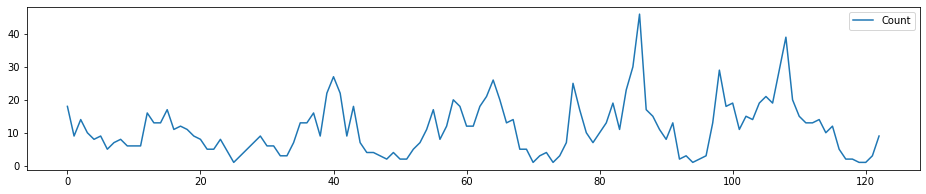

In [9]:
train_set[:120].plot(figsize=(16,3))

## Data cleaning and transformation

Before we can start buinding a model, we need to ensure the data is **stationary**. We will use the Augmented Dickey-Fuller (ADF) test and the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests to test the series for stationarity.

<font size="5">**Augmented Dickey-Fuller**</font>

ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. 

Tests whether a time series has a unit root, e.g. has a trend or more generally is autoregressive.

**Assumptions**

Observations in are temporally ordered.

**Interpretation**

* H0: a unit root is present (series is non-stationary).
* H1: a unit root is not present (series is stationary).



<font size="5">**Kwiatkowski-Phillips-Schmidt-Shin**</font> (KPSS) test

The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

**Assumptions**

Observations in are temporally ordered.

**Interpretation**

* H0: the time series is not trend-stationary.
* H1: the time series is trend-stationary.




Missing values are not handled.


[statsmodels.org/stationarity_detrending_adf_kpss](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [10]:
from statsmodels.tsa.stattools import adfuller, kpss

adf_pval = adfuller(train_set['Count'], maxlag=10, regression='nc')[1]
print("ADF, p-value:", adf_pval)

ADF, p-value: 5.622377150770526e-24


In [11]:
kpss_stat, kpss_pval, lags, crit_vals = kpss(train_set['Count'])
print("KPSS, p-value:", round(kpss_pval,2))

KPSS, p-value: 0.01


**InterpolationWarning**

InterpolationWarning is issued when the test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is {direction} than the p-value returned. Not present for ADF.

    if p_value == pvals[-1]:
        warnings.warn(
            warn_msg.format(direction="smaller"), InterpolationWarning
        )
    elif p_value == pvals[0]:
        warnings.warn(
            warn_msg.format(direction="greater"), InterpolationWarning
        )


[Source code](https://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools.html)




### Function Trending

Function Trending takes as arguments adf_pval and kpss_stat values.

In [12]:
def Trending(adf_pval, kpss_stat):
    if adf_pval>0.05 and kpss_pval < 0.05:
        return "non-Stationary"
    elif adf_pval<0.05 and kpss_pval > 0.05:
        return "Stationary"
    elif adf_pval>0.05 and kpss_pval > 0.05:
        return "3: ADF : non-Stationary, KPSS : Stationary"
    elif adf_pval<0.05 and kpss_pval < 0.05:
        return "ADF : Stationary, KPSS : non-Stationary"

In [13]:
Trending(adf_pval,kpss_pval )

'ADF : Stationary, KPSS : non-Stationary'

The series is not stationary in the levels (i.e., in the original form), according to the KPSS test, but it is stationary according to the ADF test. So it would be safer to assume that the series is not stationary. Let us difference it.

In [14]:
train_diff = train_set['Count'].diff().dropna()

adf_pval = adfuller(train_diff, maxlag=10, regression="nc")[1]
kpss_stat, kpss_pval, lags, crit_vals = kpss(train_diff)
Trending(adf_pval, kpss_pval)

'Stationary'

The series has become stationary after the first differencing, so we'll use a differenced training set for building a model and we'll also difference the test data in order to be able to evaluate the model.

In [15]:
test_diff = test_set['Count'].diff().dropna()

## Build models

### Baseline

The persistence baseline is generating the previous hours accidents as the prediction for next hour. 

Baseline rmse is <font size="4" style = "color:red">**10.6**</font> accidents per hour.  

If baseline would be derived as average accidents per hour in the test data set, average accident per hour is 14.33 and root squared error is 16.24, which is 35% worse of a prediction than assuming last hours figure. 

In [16]:
baseline_predictions = test_diff.shift()[1:]

mse = mean_squared_error(test_diff[1:], baseline_predictions)

baseline_rmse = np.sqrt(mse)
baseline_rmse

10.566832886189484

In [17]:
a = np.empty(len(test_diff[1:]))
a.fill(test_set['Count'].mean())
np.sqrt(mean_squared_error(test_diff[1:], a))

16.41803112782183

### Extra transformation steps

We need to do some transformation steps required to be able to input the data into the scikit-learn's implementation of the ML algorithms.

In [18]:
def create_ar_vars(ts, lags=3):
    """Create autoregressive X variables
    """
    dataX, dataY = [], []
    for i in range(len(ts)-lags):
        dataX.append(ts[i:i + lags, 0])
        dataY.append(ts[i + lags, 0])
    return np.array(dataX), np.array(dataY)

We first create separate arrays for the predictors and the target, for both the training and test data. We'll use 3 lags to create autoregressive variables.

In [19]:
Xtrain, ytrain = create_ar_vars(train_diff.values.reshape(-1, 1), lags=3)
Xtest, ytest = create_ar_vars(test_diff.values.reshape(-1, 1), lags=3)

Both predictor arrays need to be scaled (but the target variable should not be transformed).

Standardization of a dataset is a common requirement for many
machine learning estimators: they might behave badly if the
individual features do not more or less look like standard normally
distributed data.

For instance many elements used in the objective function of
a learning algorithm (such as the RBF kernel of Support Vector
Machines or the L1 and L2 regularizers of linear models) assume that
all features are centered around 0 and have variance in the same
order. If a feature has a variance that is orders of magnitude larger
that others, it might dominate the objective function and make the
estimator unable to learn from other features correctly as expected.

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

Then we can use a grid search to find the most optimal hyperparameters settings.

### Decision Tree regression

`max_depth`

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. 

`min_samples_split`

The minimum number of samples required to split an internal node

`n_splits` 

Time Series cross-validator, this data set is split 10 times in order to cross validate. Each successive training set is supersets of those that come before them.

`GridSearchCV` will iterate over all possible combinations of `max_depth` and `min_samples_split`, and evaluates each combination using cross-validation. The output is the model with the best cross-validation accuracy.

In [21]:
dtree = DecisionTreeRegressor(random_state=7)
param_grid = [
    {'max_depth': [6, 8, 10, 7],
    'min_samples_split': [6, 8, 10, 11, 9]}
]

tscv = TimeSeriesSplit(n_splits=10)
dtree_grid_search = GridSearchCV(estimator=dtree, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

dtree_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=7, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [6, 8, 10, 7],
                          'min_samples_split': [6, 8, 10, 11, 9]}],
             pre_dis

Let's print the accuracy scores for every model evaluated during the grid search.

In [22]:
val_scores = dtree_grid_search.cv_results_["mean_test_score"]
train_scores = dtree_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in dtree_grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(f"{np.sqrt(-val_score):.3f}, {np.sqrt(-train_score):.3f}, {np.sqrt(-val_score)/np.sqrt(-train_score):.3f}", param)

7.225, 6.464, 1.118 {'max_depth': 6, 'min_samples_split': 10}
7.229, 6.470, 1.117 {'max_depth': 6, 'min_samples_split': 11}
7.233, 6.451, 1.121 {'max_depth': 6, 'min_samples_split': 9}
7.242, 6.446, 1.123 {'max_depth': 6, 'min_samples_split': 8}
7.255, 6.432, 1.128 {'max_depth': 6, 'min_samples_split': 6}
7.273, 6.356, 1.144 {'max_depth': 7, 'min_samples_split': 11}
7.282, 6.345, 1.148 {'max_depth': 7, 'min_samples_split': 10}
7.293, 6.327, 1.153 {'max_depth': 7, 'min_samples_split': 9}
7.312, 6.316, 1.158 {'max_depth': 7, 'min_samples_split': 8}
7.342, 6.227, 1.179 {'max_depth': 8, 'min_samples_split': 11}
7.343, 6.290, 1.167 {'max_depth': 7, 'min_samples_split': 6}
7.364, 6.210, 1.186 {'max_depth': 8, 'min_samples_split': 10}
7.377, 6.188, 1.192 {'max_depth': 8, 'min_samples_split': 9}
7.395, 6.175, 1.198 {'max_depth': 8, 'min_samples_split': 8}
7.427, 6.137, 1.210 {'max_depth': 8, 'min_samples_split': 6}
7.502, 5.946, 1.262 {'max_depth': 10, 'min_samples_split': 11}
7.516, 5.917, 1.

After fitting initial param_grid

`
param_grid = [
    {'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8]}
]
`

the best performing values were 8, therefore 9, 10, 11 is added and 2 & 4 is removed from param_grid.

After tuning the hyperparameters, the best performing pair is 'max_depth': 6, 'min_samples_split': 10

### Random Forest regression

`n_estimators`

The number of trees in the forest.

`max_depth`

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. 

`min_samples_split`

The minimum number of samples required to split an internal node

`n_splits` 

Time Series cross-validator, this data set is split 10 times in order to cross validate. Each successive training set is supersets of those that come before them.

`GridSearchCV` will iterate over all possible combinations of `n_estimators`, `max_depth` and `min_samples_split`, and evaluates each combination using cross-validation. The output is the model with the best cross-validation accuracy.

In [23]:
rf = RandomForestRegressor(random_state=7)
param_grid = [
    {'n_estimators': [20, 30, 40, 50, 60, 55, 35], 
     'max_depth': [8],
     'min_samples_split': [8, 10]
    },
]

tscv = TimeSeriesSplit(n_splits=10)
rf_grid_search = GridSearchCV(estimator=rf, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
rf_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=7,
                                             verbose

Let's print the accuracy scores for every model evaluated during the grid search.

In [24]:
val_scores = rf_grid_search.cv_results_["mean_test_score"]
train_scores = rf_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in rf_grid_search.cv_results_["params"]]
   
for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(f"{np.sqrt(-val_score):.3f}, {np.sqrt(-train_score):.3f}, {np.sqrt(-val_score)/np.sqrt(-train_score):.3f}", param)

6.896, 6.089, 1.133 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 55}
6.896, 6.119, 1.127 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 20}
6.897, 6.088, 1.133 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 60}
6.898, 6.091, 1.132 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 50}
6.900, 6.054, 1.140 {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 55}
6.900, 6.052, 1.140 {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 60}
6.901, 6.105, 1.130 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 35}
6.901, 6.057, 1.139 {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 50}
6.903, 6.098, 1.132 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 40}
6.905, 6.087, 1.134 {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 20}
6.905, 6.070, 1.137 {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 35}
6.906, 6.104, 1.131 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 30}
6.907, 6.064, 1.139 {

Initial param_grid
param_grid = [
    {'n_estimators': [2, 4, 6, 8, 10], 
     'max_depth': [2, 4, 6, 8],
     'min_samples_split': [ 2, 4, 6, 8]
    },
]

best performing `'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 10`

after tuning `'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 55`

The best models with both DT and RF methods do not seem to overfit too much, and their cross-validation RMSEs are quite above the baseline.

## Evaluate the best DT and RF models on the test data

**Decision tree**

In [25]:
best_model = dtree_grid_search.best_estimator_

yhat = best_model.predict(Xtest)

dtree_mse = mean_squared_error(ytest, yhat)
dtree_rmse = np.sqrt(dtree_mse)
dtree_rmse

7.334111718843229

**Random forrest**

In [26]:
best_model = rf_grid_search.best_estimator_

yhat = best_model.predict(Xtest)

rf_mse = mean_squared_error(ytest, yhat)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

7.174905073228041

## Forecasting results


The best Decision Tree regression model's RMSE is **7.33** (reduced the RMSE rate by <font style= "color:red"> **30%** </font>)

The RandomForest regression method's RMSE is **7.17** (reduced the RMSE rate by <font style= "color:red"> **32%** </font>)

# Feature generation for regression

Can the error be reduced by generation additional features and using regression instead of time series forecasting. 

## Distribution plots 

First three columns are not included. 
`'datetime', 'Count'` will have long production time while producing little benefit. 

`'Count'` could be grouped into categories and from regression it would become a classification problem.

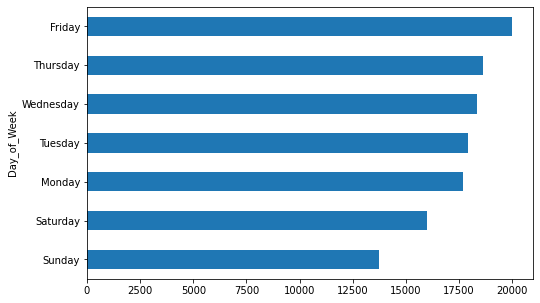

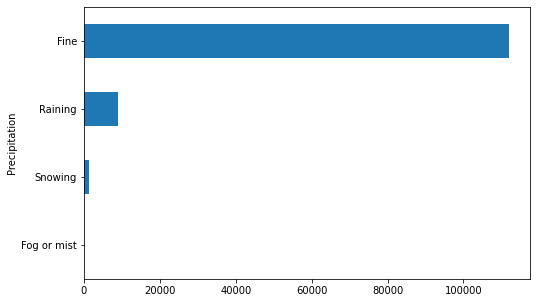

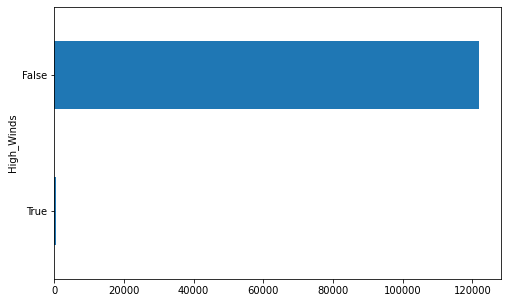

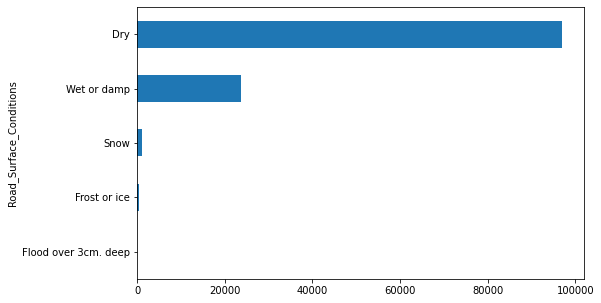

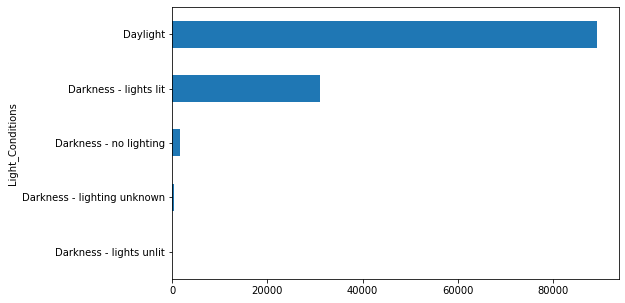

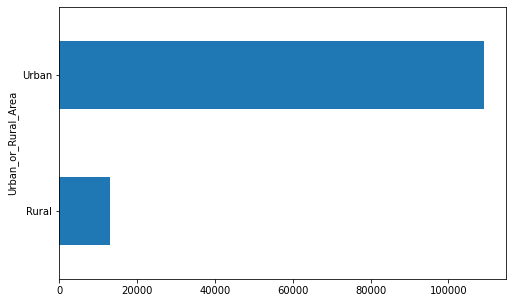

In [27]:
for i in df.columns[2:]:
    plt.figure(figsize=(8, 5))
    ax = df.groupby(i)['Count'].agg('sum').sort_values(ascending=False).plot(kind="barh")
    ax.invert_yaxis()
    plt.show()
    print()

Based on the distribution charts above, when majority accidents happen weather conditions are fine (Precipitation - Fine, road is dry, no High winds).

The most accidents happen on `Friday` (20003 accidents in total), Thursday (18640), Wednesday(18371).

The least accidents happen on `Sunday` (13760, 2/3 of Fridays accidents).

### Function TimeSplit
It takes datetime column and derives following new features:
* Hour (0-23)
* dayofweek (1-7)
* quarter (1-4)
* month(1-12)
* dayofyear (1-365)
* dayofmonth(1-31)
* weekofyear(1-52)

Extracting year does not serve any purpose as data set contains only 2018.

In [28]:
def TimeSplit(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['datetime'] = pd.to_datetime(df['datetime'], format="%d/%m/%Y %H:%M" , errors='coerce')
    df['Hour'] = df['datetime'].dt.hour
    #df['Dayofweek'] = df['datetime'].dt.dayofweek+1
    df['Quarter'] = df['datetime'].dt.quarter
    df['Month'] = df['datetime'].dt.month
    #df['year'] = df['Date'].dt.year
    #df['dayofyear'] = df['datetime'].dt.dayofyear
    df['Dayofmonth'] = df['datetime'].dt.day
    df['Weekofyear'] = df['datetime'].dt.weekofyear
    
    
    X = df[['Hour','Quarter','Month','Dayofmonth','Weekofyear'
            #,'year','dayofyear','Dayofweek'
            ]]
    return X

In [29]:
TimeSplit(df)

,Hour,Quarter,Month,Dayofmonth,Weekofyear
0,0,1,1,1,1
1,1,1,1,1,1
2,2,1,1,1,1
3,3,1,1,1,1
4,4,1,1,1,1
...,...,...,...,...,...
8535,19,4,12,31,1
8536,20,4,12,31,1
8537,21,4,12,31,1
8538,22,4,12,31,1


### Function TimeOfDay 

It takes hour derived with the previous function and splits in 5 categories:
* morning rush (5-10)
* office hours (10-15)
* afternoon rush (15-19)
* evening (19-23)
* night (23-5)

In [30]:
def TimeOfDay(hour):
    if hour >= 5 and hour < 10:
        return "Morning rush (5-10)"
    elif hour >= 10 and hour < 15:
        return "Office hours (10-15)"
    elif hour >= 15 and hour < 19:
        return "Afternoon rush (15-19)"
    elif hour >= 19 and hour < 23:
        return "Evening (19-23)"
    else:
        return "Night (23-5)"

In [31]:
df['Time_of_Day'] = df['Hour'].apply(TimeOfDay)

Package holidays are imported and respective holidays for England in 2018 is appended to dataframe bank_holidays. 
United_Kingdom contains holidays for Scotland, Wales and Ireland, which are not Bank holidays across all United Kingdom. 

In [32]:
import holidays 
uk_holidays = holidays.UnitedKingdom() 
bank_holidays = []

for ptr in holidays.England(years = 2018).items(): 
    bank_holidays.append(str(ptr[0]))

### Function Is_it_weekend 
Returning 1 if it is Sunday, Saturday or Bank Holiday in England. Assuming that driving pattern would change on those days as there is no commute to school/work for majority.

In [33]:
def is_it_weekend(x):
    m = x.normalize()
    if m.dayofweek+1 == 6:
        return 1
    elif m.dayofweek+1 == 7:
        return 1
    elif str(m.date()) in bank_holidays:
        return 1
    else:
        return 0

In [34]:
df['Is_weekend'] = df.datetime.apply(is_it_weekend)

In [35]:
#Function to change True/False to 1/0

def Liking(x):
    if str.lower(str(x)) == "true":
        return 1
    else:
        return 0 

`High_Winds` is transformed from True and False to 1/0.

In [36]:
df.High_Winds = df.High_Winds.apply(Liking)

Create a new feature "Urban" based on Urban_or_Rural_Area. Returns 1 if Urban and 0 if Rural. 
Deletes column Urban_or_Rural_Area.
This is done so column name does not become extremely long and confusing. One hot encoding would create column named "Urban_or_Rural_Area_Urban". 
In case of using SHAP to explain machine learning model, approximately one third of variable name would be displayed, which in result would not aid in explaining black box of machine learning. 

In [37]:
df['Urban']= np.where(df['Urban_or_Rural_Area'] == "Urban" , 1, 0)
del df['Urban_or_Rural_Area']

In [38]:
df.describe()

,Count,High_Winds,Hour,Quarter,Month,Dayofmonth,Weekofyear,Is_weekend,Urban
count,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000
mean,14.505689,0.008177,11.795094,2.518369,6.547997,15.738327,26.536857,0.313344,0.807300
std,10.455079,0.090063,6.833816,1.113807,3.437139,8.801340,15.000976,0.463881,0.394443
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,0.000000,6.000000,2.000000,4.000000,8.000000,14.000000,0.000000,1.000000
50%,13.000000,0.000000,12.000000,3.000000,7.000000,16.000000,27.000000,0.000000,1.000000
75%,21.000000,0.000000,18.000000,4.000000,10.000000,23.000000,40.000000,1.000000,1.000000
max,62.000000,1.000000,23.000000,4.000000,12.000000,31.000000,52.000000,1.000000,1.000000


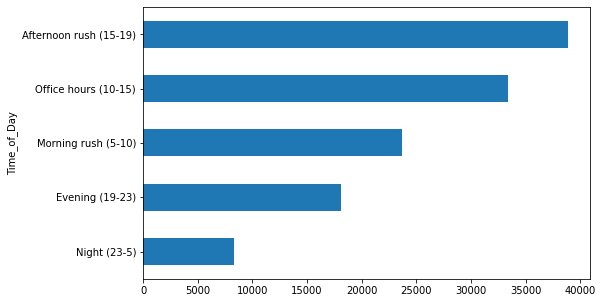

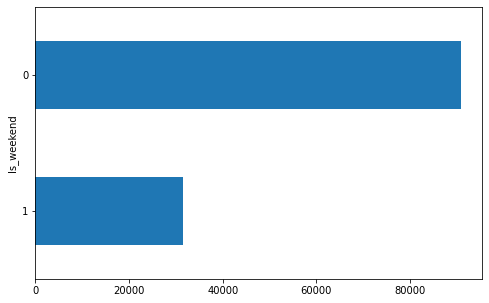

In [39]:
for i in df[['Time_of_Day', 'Is_weekend']]:
    plt.figure(figsize=(8, 5))
    ax = df.groupby(i)['Count'].agg('sum').sort_values(ascending=False).plot(kind="barh")
    ax.invert_yaxis()
    plt.show()
    print()

## Create  dummies 

In [40]:
df2 = pd.get_dummies(df, drop_first=True)

In [41]:
df2.sample(5).T

,4750,7753,5653,3722,7517
datetime,2018-07-23 15:00:00,2018-11-28 11:00:00,2018-08-30 23:00:00,2018-06-09 20:00:00,2018-11-18 11:00:00
Count,25,9,5,15,13
High_Winds,0,0,0,0,0
Hour,15,11,23,20,11
Quarter,3,4,3,2,4
Month,7,11,8,6,11
Dayofmonth,23,28,30,9,18
Weekofyear,30,48,35,23,46
Is_weekend,0,0,0,1,1
Urban,1,1,1,1,1


In [42]:
corr_matrix = df2.corr()
corr_matrix['Count'].sort_values(ascending=False)

Count                                           1.000000
Light_Conditions_Daylight                       0.455375
Hour                                            0.365645
Urban                                           0.301672
Time_of_Day_Office hours (10-15)                0.191140
Day_of_Week_Thursday                            0.041966
Weekofyear                                      0.041304
Quarter                                         0.035880
Month                                           0.035640
Day_of_Week_Wednesday                           0.034674
Day_of_Week_Tuesday                             0.030162
Day_of_Week_Monday                              0.002505
Dayofmonth                                     -0.003169
Road_Surface_Conditions_Frost or ice           -0.019573
Road_Surface_Conditions_Flood over 3cm. deep   -0.028196
Precipitation_Snowing                          -0.039278
Road_Surface_Conditions_Snow                   -0.046214
Day_of_Week_Saturday           

# Linear regression

Data set with newly generated features is split in the same manner as for forecasting time series.

In [43]:
train_set, test_set = train_test_split(df2, test_size=0.1, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

7594 train and 844 test instances


In [44]:
predictors = ['High_Winds', 'Hour', 'Quarter', 'Month',
       'Dayofmonth', 'Weekofyear', 'Is_weekend', 'Urban', 'Day_of_Week_Monday',
       'Day_of_Week_Saturday', 'Day_of_Week_Sunday', 'Day_of_Week_Thursday',
       'Day_of_Week_Tuesday', 'Day_of_Week_Wednesday',
       'Precipitation_Fog or mist', 'Precipitation_Raining',
       'Precipitation_Snowing', 'Road_Surface_Conditions_Flood over 3cm. deep',
       'Road_Surface_Conditions_Frost or ice', 'Road_Surface_Conditions_Snow',
       'Road_Surface_Conditions_Wet or damp',
       'Light_Conditions_Darkness - lights lit',
       'Light_Conditions_Darkness - lights unlit',
       'Light_Conditions_Darkness - no lighting', 'Light_Conditions_Daylight',
       'Time_of_Day_Evening (19-23)', 'Time_of_Day_Morning rush (5-10)',
       'Time_of_Day_Night (23-5)', 'Time_of_Day_Office hours (10-15)']

Xtrain = train_set[predictors]
ytrain = train_set['Count']

Xtest = test_set[predictors]
ytest = test_set['Count']


In [45]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
# make predictions
yhat = lin_reg.predict(Xtrain)

lin_mse = mean_squared_error(ytrain, yhat)

# take square root
lin_rmse = np.sqrt(lin_mse)

lin_rmse

6.877592809712238

Linear regression in combination with feature engineering, produces root mean squared error of 
 **6.88** , which is <font style= "color:red"> **35%** </font> reduction in error compared to the baseline (previous hours accidents). For comparison, forecasting the time series using Random Forest method produced 32% improvement. 
 
Further we will investigate how much error rate can be reduced even further, applying Decision tree and Random forest regressions.

The same steps as in **2.3.3 & 2.3.4, 2.4** will be followed.

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

# Decision Tree regression

Refer to the 2.3.3 for explanation of hyperparameters. 

In [48]:
dtree = DecisionTreeRegressor(random_state=7)
param_grid = [
    {'max_depth': [6, 7, 8],
    'min_samples_split': [6, 8, 10, 9]}
]

tscv = TimeSeriesSplit(n_splits=10)
dtree_grid_search = GridSearchCV(estimator=dtree, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
dtree_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=7, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [6, 7, 8],
                          'min_samples_split': [6, 8, 10, 9]}],
             pre_dispatch='2

In [49]:
val_scores = dtree_grid_search.cv_results_["mean_test_score"]
train_scores = dtree_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in dtree_grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(f"{np.sqrt(-val_score):.3f}, {np.sqrt(-train_score):.3f}, {np.sqrt(-val_score)/np.sqrt(-train_score):.3f}", param)

5.645, 5.217, 1.082 {'max_depth': 6, 'min_samples_split': 10}
5.645, 5.213, 1.083 {'max_depth': 6, 'min_samples_split': 8}
5.648, 5.214, 1.083 {'max_depth': 6, 'min_samples_split': 9}
5.650, 5.212, 1.084 {'max_depth': 6, 'min_samples_split': 6}
5.810, 4.604, 1.262 {'max_depth': 8, 'min_samples_split': 9}
5.841, 4.609, 1.267 {'max_depth': 8, 'min_samples_split': 10}
5.843, 4.928, 1.186 {'max_depth': 7, 'min_samples_split': 9}
5.861, 4.917, 1.192 {'max_depth': 7, 'min_samples_split': 6}
5.869, 4.590, 1.279 {'max_depth': 8, 'min_samples_split': 8}
5.883, 4.920, 1.196 {'max_depth': 7, 'min_samples_split': 8}
5.891, 4.580, 1.286 {'max_depth': 8, 'min_samples_split': 6}
5.935, 4.932, 1.203 {'max_depth': 7, 'min_samples_split': 10}


# Random Forest regression

Refer to the 2.3.4 for explanation of hyperparameters. 

In [50]:
rf = RandomForestRegressor(random_state=7)
param_grid = [
    {'n_estimators': [20, 30, 40, 50, 25], 
     'max_depth': [8, 10],
     'min_samples_split': [ 10, 11, 12]
    },
]

tscv = TimeSeriesSplit(n_splits=10)
rf_grid_search = GridSearchCV(estimator=rf, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
rf_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=7,
                                             verbose

Let's print the accuracy scores for every model evaluated during the grid search.

In [51]:
val_scores = rf_grid_search.cv_results_["mean_test_score"]
train_scores = rf_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in rf_grid_search.cv_results_["params"]]
   
for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(f"{np.sqrt(-val_score):.3f}, {np.sqrt(-train_score):.3f}, {np.sqrt(-val_score)/np.sqrt(-train_score):.3f}", param)

5.496, 4.455, 1.234 {'max_depth': 8, 'min_samples_split': 12, 'n_estimators': 25}
5.498, 4.447, 1.237 {'max_depth': 8, 'min_samples_split': 12, 'n_estimators': 30}
5.500, 4.459, 1.234 {'max_depth': 8, 'min_samples_split': 12, 'n_estimators': 20}
5.503, 4.437, 1.240 {'max_depth': 8, 'min_samples_split': 12, 'n_estimators': 50}
5.504, 4.449, 1.237 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 20}
5.504, 4.444, 1.238 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 25}
5.504, 4.427, 1.243 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 50}
5.506, 4.436, 1.241 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 30}
5.510, 4.418, 1.247 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 50}
5.511, 4.448, 1.239 {'max_depth': 8, 'min_samples_split': 12, 'n_estimators': 40}
5.512, 3.938, 1.400 {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 50}
5.514, 4.437, 1.243 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 40}
5.515, 4.435, 1

## Evaluate the best DT and RF models on the test data

**Decision tree**

In [52]:
best_model = dtree_grid_search.best_estimator_

yhat = best_model.predict(Xtest)

dtree_mse = mean_squared_error(ytest, yhat)
dtree_rmse = np.sqrt(dtree_mse)
dtree_rmse

6.510712307172764

**Random forrest**

In [53]:
best_model = rf_grid_search.best_estimator_

yhat = best_model.predict(Xtest)

rf_mse = mean_squared_error(ytest, yhat)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

6.396903039403599

## Regression results


The best Decision Tree regression model's RMSE is **6.51** (reduced the RMSE rate by <font style= "color:red"> **38%** </font>)

The RandomForest regression method's RMSE is **6.39** (reduced the RMSE rate by <font style= "color:red"> **39.5%** </font>)

## 5.5 Analyze the most promising models

We can examine what variables were the most important for the regression problem in the best-performing model. They are also stored as an attribute on the model object:

In [70]:
# put them into a separate variable for convenience
feature_importances = rf_grid_search.best_estimator_.feature_importances_

# the order of the features in `feature_importances` is the same as in the Xtrain dataframe,
# so we can "zip" the two and print in the descending order:

for k, v in sorted(zip(feature_importances, predictors), reverse=True):
    print(f"{v}: {k:.3f}")

Hour: 0.801
Is_weekend: 0.069
Weekofyear: 0.037
Time_of_Day_Office hours (10-15): 0.032
Time_of_Day_Morning rush (5-10): 0.016
Time_of_Day_Evening (19-23): 0.016
Dayofmonth: 0.007
Month: 0.005
Day_of_Week_Saturday: 0.005
Urban: 0.003
Light_Conditions_Darkness - lights lit: 0.003
Day_of_Week_Monday: 0.001
Day_of_Week_Sunday: 0.001
Day_of_Week_Tuesday: 0.001
Precipitation_Raining: 0.001
Road_Surface_Conditions_Wet or damp: 0.001
Time_of_Day_Night (23-5): 0.001


# Random Forest regression - less features

Refer to the 2.3.4 for explanation of hyperparameters. 

In [62]:
train_set, test_set = train_test_split(df2, test_size=0.1, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

7594 train and 844 test instances


In [63]:
predictors = ['Hour', 'Month',
       'Dayofmonth', 'Weekofyear', 'Is_weekend', 'Urban', 'Day_of_Week_Monday',
       'Day_of_Week_Saturday', 'Day_of_Week_Sunday', 
       'Day_of_Week_Tuesday', 'Precipitation_Raining',
       'Road_Surface_Conditions_Wet or damp',
       'Light_Conditions_Darkness - lights lit',
       'Time_of_Day_Evening (19-23)', 'Time_of_Day_Morning rush (5-10)',
       'Time_of_Day_Night (23-5)', 'Time_of_Day_Office hours (10-15)']

Xtrain = train_set[predictors]
ytrain = train_set['Count']

Xtest = test_set[predictors]
ytest = test_set['Count']


In [67]:
rf = RandomForestRegressor(random_state=7)
param_grid = [
    {'n_estimators': [20, 30, 40, 50, 25, 55], 
     'max_depth': [8, 10],
     'min_samples_split': [ 10, 11, 12]
    },
]

tscv = TimeSeriesSplit(n_splits=10)
rf_grid_search = GridSearchCV(estimator=rf, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
rf_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=7,
                                             verbose

Let's print the accuracy scores for every model evaluated during the grid search.

In [68]:
val_scores = rf_grid_search.cv_results_["mean_test_score"]
train_scores = rf_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in rf_grid_search.cv_results_["params"]]
   
for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(f"{np.sqrt(-val_score):.3f}, {np.sqrt(-train_score):.3f}, {np.sqrt(-val_score)/np.sqrt(-train_score):.3f}", param)

5.482, 4.422, 1.240 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 50}
5.483, 4.442, 1.235 {'max_depth': 8, 'min_samples_split': 12, 'n_estimators': 50}
5.484, 4.441, 1.235 {'max_depth': 8, 'min_samples_split': 12, 'n_estimators': 55}
5.487, 4.421, 1.241 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 55}
5.487, 4.449, 1.233 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 25}
5.488, 4.460, 1.231 {'max_depth': 8, 'min_samples_split': 12, 'n_estimators': 25}
5.488, 4.431, 1.239 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 50}
5.489, 4.453, 1.232 {'max_depth': 8, 'min_samples_split': 12, 'n_estimators': 30}
5.490, 4.440, 1.237 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 25}
5.490, 4.430, 1.239 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 55}
5.491, 4.434, 1.238 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 30}
5.493, 4.433, 1.239 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 40}
5.495, 4.443, 1.

In [69]:
best_model = rf_grid_search.best_estimator_

yhat = best_model.predict(Xtest)

rf_mse = mean_squared_error(ytest, yhat)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

6.408804819733202

# Summary 
TL;DR

- Play with lags
- Additional feature engineering
Explore if 
- XGboost
- Represent time as sin/cos
- Tensorflow/pytoch/FastAI
- Data on terms and halfterms